# Objectifs

Les objectifs de la leçon sont les suivants:
* Fit une régression logistique avec `scikit-learn`
* Fit un arbre de classification avec `scikit-learn`
* Interpreter les résultats de la régression logistique
* Visualiser et interpréter le fit d'un arbre de classification

# Importer les librairies

In [1]:
import pandas as pd 
import numpy as np
import os
pd.set_option('mode.chained_assignment', None) # ignorer certains warnings

# Data
from sklearn import datasets

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Loader les données

In [25]:
# Loader les données
iris = datasets.load_iris()

# Obtenir les features
features = pd.DataFrame(
    data=iris.data,
    columns=iris.feature_names
)
# Obtenir la target
target = pd.DataFrame(
    data=iris.target,
    columns=["species"]
)
def target_converter(sp):
    """Apply strings to integers for the targets."""
    if sp == 0:
        return "setosa"
    elif sp == 1:
        return "versicolor"
    else:
        return "virginica"
target["species"] = target["species"].apply(target_converter)

# Concaténer les features et la target dans une meme dataframe
data = pd.concat([features, target], axis=1)

data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
# On drop pour l'analyse les lignes où l'espèce est setosa 
data = data[data["species"] != "setosa"]

data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [26]:

# On drop les variables petal width et petal length
data.drop(columns=["petal length (cm)", "petal width (cm)"], inplace=True)

data

,sepal length (cm),sepal width (cm),species
0,5.1,3.5,setosa
1,4.9,3.0,setosa
2,4.7,3.2,setosa
3,4.6,3.1,setosa
4,5.0,3.6,setosa
...,...,...,...
145,6.7,3.0,virginica
146,6.3,2.5,virginica
147,6.5,3.0,virginica
148,6.2,3.4,virginica


**L'objectif de la classification est d'analyser si l'espèce est une virginica (1) ou versicolor (0). Le jeu de données contient 100 observations et 2 variables indépendentes (la longeur et la largeur des sépales).**

# EDA rapide

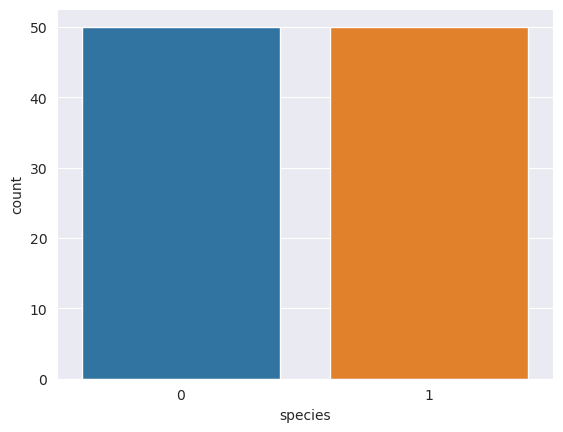

In [5]:
# Plot de la variable à classifier
sns.countplot(
    x="species", 
    data=data
)
plt.show()

/home/guillaume/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/guillaume/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/guillaume/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


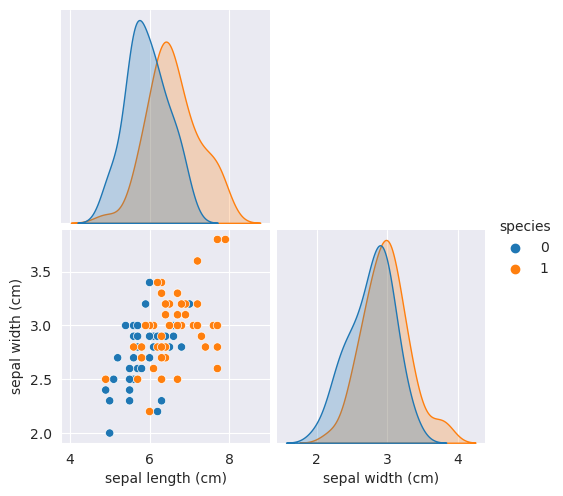

In [6]:
# Etudier la relation entre les variables, selon les species
sns.pairplot(
    data=data,
    hue="species",
    corner=True # pour eviter d'avoir les scatter plots en double
)
plt.show()

# Régression logistique

Pour une première régression logistique, nous allons produire le model suivant:

$$ \text{Prob}(\underbrace{\text{virginica}}_{y}) = \sigma (\text{b} 
                        + \underbrace{a_1 \cdot \text{sepal length (cm)} 
                        + a_2 \cdot \text{sepal width (cm)}}_{X}) $$
                        
La fonction $\text{sig}(t)$, appelée **sigmoïde**, est de la forme suivante:

<img src="Images/sigmoid.png">

Pour cela, nous allons utiliser la fonction [`statsmodels.Logit`](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html). 

## Préparation des données pour le model

Comme pour la régression linéaire, il faut que nous séparions en deux dataframes les features (toutes les variables sauf `species`) et la target (`species`). On dénote les features X, et la target y.

In [7]:
# Séparer les features et la target
X = data.drop(columns=["species"]) # toutes les colonnes sauf species, qui est notre target
y = data["species"]

## Fit le modèle

In [8]:
# Générer un model de régression logistique
model = sm.Logit(
    y,
    sm.add_constant(X) # il faut rajouter une constante, qui n'est pas là par défaut
)

# Fit le model
model_fit = model.fit()

# Quel est le résumé?
print(model_fit.summary())

Optimization terminated successfully.
         Current function value: 0.551629
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                species   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Tue, 27 Feb 2024   Pseudo R-squ.:                  0.2042
Time:                        09:39:17   Log-Likelihood:                -55.163
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 7.144e-07
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -13.0460      3.097     -4.212      0.000     -19.117      -6.975
sepal le

In [9]:
# On récupère les coefficients
coefs = model_fit.params.tolist()

coefs

[-13.046029653370864, 1.9023752189568446, 0.40465941223015023]

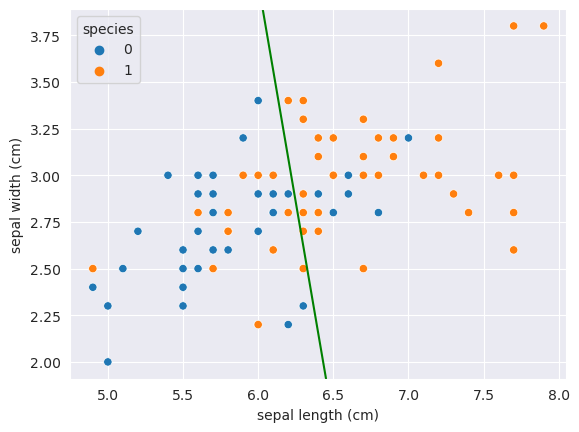

In [10]:
sns.scatterplot(
    x="sepal length (cm)",
    y="sepal width (cm)",
    data=data,
    hue="species"
)
# On calcule 2 points au hasard dans notre dataframe
x1 = (-coefs[0] - coefs[2]*data.iloc[0,1])/coefs[1]
x2 = (-coefs[0] - coefs[2]*data.iloc[4,1])/coefs[1]
plt.axline((x1, data.iloc[0,1]), (x2, data.iloc[4,1]), color = "green")
plt.show()

L'**odd ratio** peut être défini comme le rapport de côtes de probabilité que l'espèce soit une versicolor et la probabilité que l'espèce ne soit pas une versicolor. On l'interprète de la manière suivante:
* OR = 1: l'espèce est indépendente du feature.
* OR > 1: l'espèce virginica est plus probable pour le feature.
* OR < 1: l'espèce virginica n'est pas probable pour le feature.

Pour calculer l'odd ratio, il suffit de prendre l'exponentiel du coefficient (voir ci-dessus).

In [11]:
# On calcule le odds ratio
odds_ratio = np.exp(model_fit.params)

pd.DataFrame(odds_ratio, columns=["Odds ratio"])

,Odds ratio
const,0.000002
sepal length (cm),6.701794
sepal width (cm),1.498792


* Pour chaque cm de longueur de sépale supplémentaire, les chances que la fleur soit une virgina augmentent de 600% (!). 
* Pour chaque cm de largeur de sépale supplémentaire, les chances que la fleur soit une virginica augmentent d'environ 50%.

# Arbre de classification

Comme pour la régression logistique, nous allons analyser la variable `species`. Pour cela, nous allons utiliser la fonction [`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

Nous pouvons utiliser les mêmes données que celles utilisées pour la régression logistique.

## Fit le modèle

In [27]:
# Générer un model d'arbre de classification
model = DecisionTreeClassifier(max_depth=3) # on utilise max_depth=3 pour ne pas avoir un arbre trop grand

# Fit le model
model_fit = model.fit(X, y)

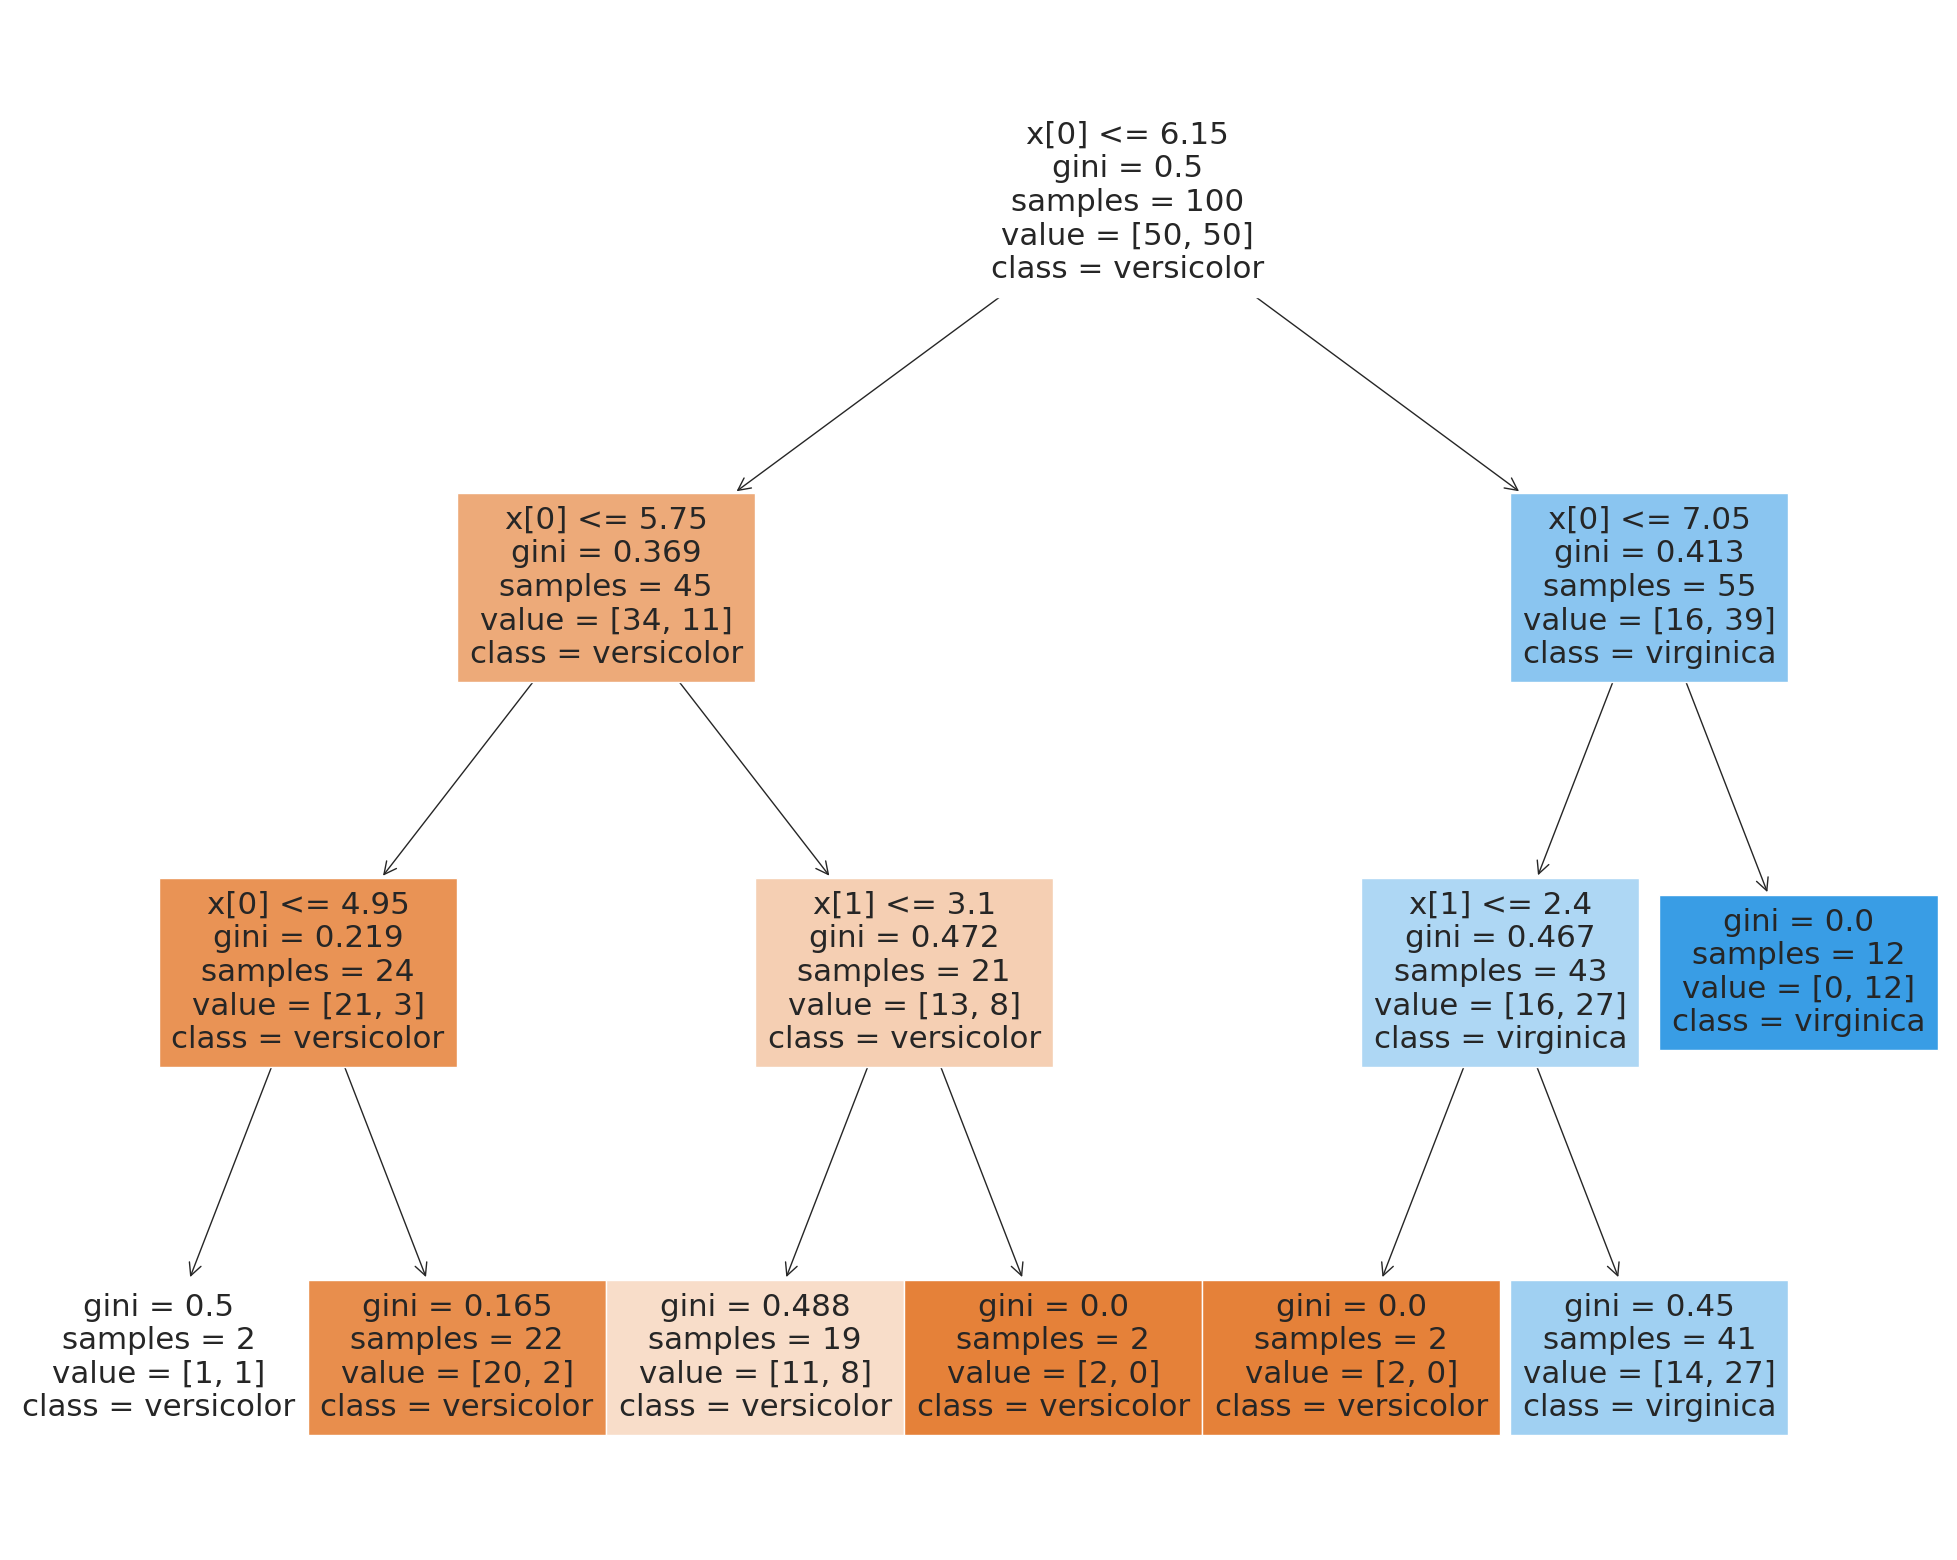

In [29]:
# Visualiser l'arbre
fig = plt.figure(figsize=(25, 20))
_ = plot_tree(
    model,
    feature_names=X.columns.tolist(),
    class_names=["versicolor", "virginica", "setosa"],
    filled=True
)